In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

In [13]:
def metrics(inlier_score, outlier_score, plot=False, verbose=False):
    import numpy as np
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

In [6]:
from scipy.ndimage import uniform_filter, median_filter

#Smooth first to get rid of spurious outliers
def preproc(x, orig=None):
    x = np.abs(uniform_filter(x, size=3))
    
    # Only consider foreground pixels
#     x = x[orig>0]
    return x

# Selecting Quantile for best separation
def getQuantiles(logits,orig, Q=0.95):    
    quants = [np.quantile(preproc(x,o), Q) for x,o in zip(logits, orig)]
    quants = np.array(quants).reshape(-1,1)
    return quants

In [7]:
TEST_BATCH = 1000

@tf.function
def preproc(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.image.resize(x, size=[28,28])
    return x

with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_test_ = get_train_test_data("fashion_mnist")[1]
    fashion_test_ = fashion_test_.shuffle(100000).batch(TEST_BATCH)

    fashion_test_batches = [x for x in fashion_test_]

In [8]:
# fashion_train = fashion_test_batches[0:-]
fashion_test = fashion_test_batches[:]
len(fashion_train), len(fashion_test)

(5, 10)

In [68]:
# with tf.device('CPU'):
#     # load dataset from tfds (or use downloaded version if exists)
#     fashion_train = get_train_test_data("fashion_mnist")[0]
#     fashion_train = fashion_train.shuffle(100000).cache().batch(1000).take(60)
# fashion_test = fashion_test_batches

In [9]:
with tf.device('CPU'):
    mnist_test = get_train_test_data("mnist")[1]
    mnist_test = mnist_test.shuffle(10000).batch(TEST_BATCH)
    mnist_test = mnist_test.cache()

    cifar_test = get_train_test_data("cifar10")[1]
    cifar_test = cifar_test.map(preproc)
    cifar_test = cifar_test.shuffle(10000).batch(TEST_BATCH)
    cifar_test = cifar_test.cache()

## Generating Samples

In [10]:
args = get_command_line_args(["--checkpoint_dir=longleaf_models/",
                              "--filters=64",
                              "--dataset=fashion_mnist",
                              "--sigma_low=0.01",
                              "--sigma_high=1"
                             ])
configs.config_values = args

BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMAS = utils.get_sigma_levels().numpy()
SIGMAS

Parameters: 

experiment: train
dataset: fashion_mnist
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: longleaf_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2



array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [11]:
utils.get_savemodel_dir()

('longleaf_models/refinenet64_fashion_mnist_L10_SH1e+00_SL1e-02/',
 'refinenet64_fashion_mnist_L10_SH1e+00_SL1e-02')

In [12]:
save_dir, complete_model_name = utils.get_savemodel_dir() # "longleaf_models/baseline64_fashion_mnist_SL0.001", ""
fashion_model, optimizer, step, _, _ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

(1, 28, 28, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 28, 28, 64)   77696       conv2d[0][0]                     
                                                                 idx_sigmas[0][

### Getting Score Distributions

In [48]:
%%time

idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * BEST_SIGMA_IDX

for fashion_,mnist_,cifar_ in zip(fashion_test,mnist_test,cifar_test):
    fashion_logits = fashion_model([fashion_, idx_sigmas])
    mnist_logits = fashion_model([mnist_, idx_sigmas])
    cifar_logits = fashion_model([cifar_, idx_sigmas])

CPU times: user 1.78 s, sys: 1.57 s, total: 3.35 s
Wall time: 2.41 s


In [49]:
# L2-norm same as Frobenius
f_train_fashion_score = tf.norm(fashion_logits, axis=[1,2], ord="euclidean").numpy()
f_train_mnist_score = tf.norm(mnist_logits, axis=[1,2], ord="euclidean").numpy()
f_train_cifar_score = tf.norm(cifar_logits, axis=[1,2], ord="euclidean").numpy()

In [50]:
df = pd.DataFrame(np.hstack((f_train_fashion_score,
                             f_train_mnist_score,
                             f_train_cifar_score)),
             columns=["Fashion", "MNIST", "Cifar"])
df.describe()

Fashion        MNIST        Cifar
count  1000.000000  1000.000000  1000.000000
mean    818.417297   756.922180  1999.237305
std     222.825256   146.556381   280.459076
min     267.049316   313.915955   819.604858
25%     652.983200   664.996429  1850.752533
50%     797.557587   766.610138  2036.967957
75%     991.397980   859.774582  2201.484070
max    1584.942627  1180.907715  2587.406494

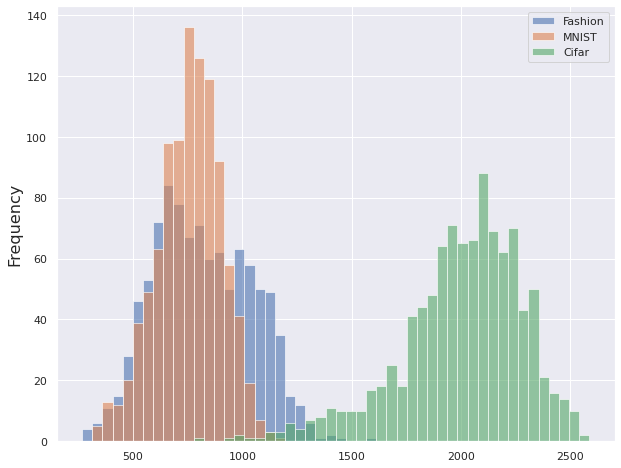

In [51]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

### Fashion vs MNIST

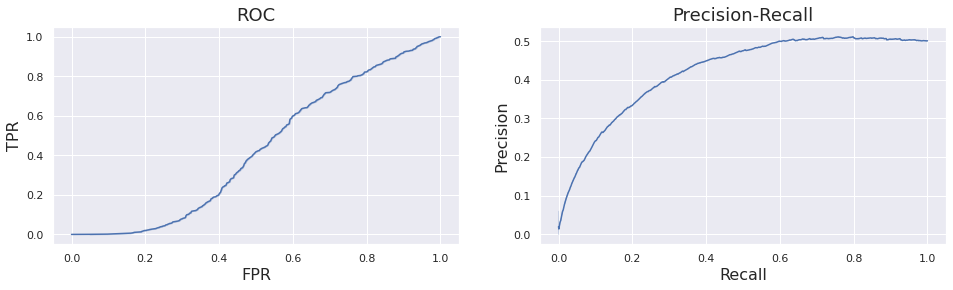

Inlier vs Outlier
----------------
ROC-AUC: 0.4275
PR-AUC: 0.4214
Avg Prec: 0.4219


In [58]:
metrics(f_train_fashion_score, f_train_mnist_score, plot=True, verbose=True)
plt.show()

In [14]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = fashion_model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [68]:
LABELS = np.array(["Train", "Fashion", "MNIST", "CIFAR"])
colors = ["red", "blue", "green", "orange"]

In [17]:
%%time
fashion_train_dist = compute_scores(fashion_train)

Sigma: 0.0100: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]

CPU times: user 14.3 s, sys: 5.98 s, total: 20.3 s
Wall time: 35.5 s


In [15]:
%%time
# fashion_train_dist = compute_scores(fashion_train)
fashion_dist = compute_scores(fashion_test)

Sigma: 0.0100: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

CPU times: user 26.1 s, sys: 13.9 s, total: 39.9 s
Wall time: 1min 5s


In [16]:
%%time
mnist_dist = compute_scores(mnist_test)
cifar_dist = compute_scores(cifar_test)

Sigma: 0.0100: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

CPU times: user 1min 5s, sys: 1min 9s, total: 2min 14s
Wall time: 2min 10s


In [75]:
fashion_train_dist[0].shape, fashion_dist[0].shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [76]:
# L2-norm same as Frobenius
train_agg = tf.add_n([fashion_train_dist[x] * s for x, s in enumerate(SIGMAS)])
inlier_agg = tf.add_n([fashion_dist[x] * s for x, s in enumerate(SIGMAS)])
outlier_agg = tf.add_n([mnist_dist[x] * s for x,s in enumerate(SIGMAS)])
outlier_agg_2 = tf.add_n([cifar_dist[x] * s for x,s in enumerate(SIGMAS)])

train_score = tf.norm(train_agg, axis=[1,2], ord="euclidean").numpy()
fashion_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
mnist_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()
cifar_score = tf.norm(outlier_agg_2, axis=[1,2], ord="euclidean").numpy()

In [77]:
df = pd.DataFrame(np.hstack((train_score[-len(fashion_score):],
                             fashion_score,
                             mnist_score[-len(fashion_score):],
                             cifar_score[-len(fashion_score):])),
             columns=["Train", "Fashion", "MNIST", "CIFAR"])
df.describe()

Train       Fashion         MNIST         CIFAR
count  10000.000000  10000.000000  10000.000000  10000.000000
mean      29.938395     73.338264     64.612488    149.292480
std        2.324399     13.330881      3.759705     21.777611
min       22.329039     39.564793     49.384815     68.431046
25%       28.334618     63.762892     62.168113    135.765732
50%       29.844122     72.237339     64.592098    150.494133
75%       31.399306     82.374416     67.134315    164.379520
max       42.440182    140.977722     82.665604    229.783051

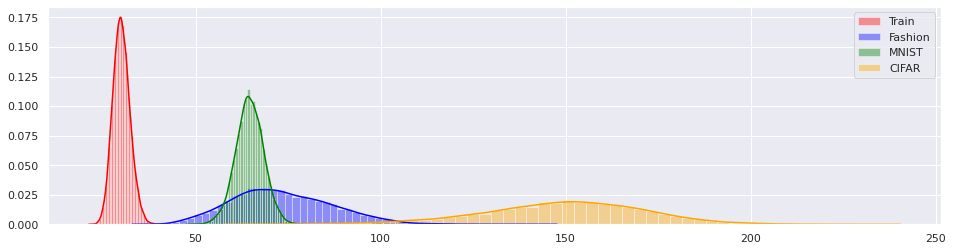

In [79]:
fig, ax = plt.subplots(1,1, figsize=(16,4))



for idx, sc in enumerate([train_score,
                             fashion_score,
                             mnist_score,
                             cifar_score]):

    sns.distplot(sc, label=LABELS[idx], color=colors[idx], ax=ax)
plt.legend()
plt.show()

**ABCD vs 1-year**

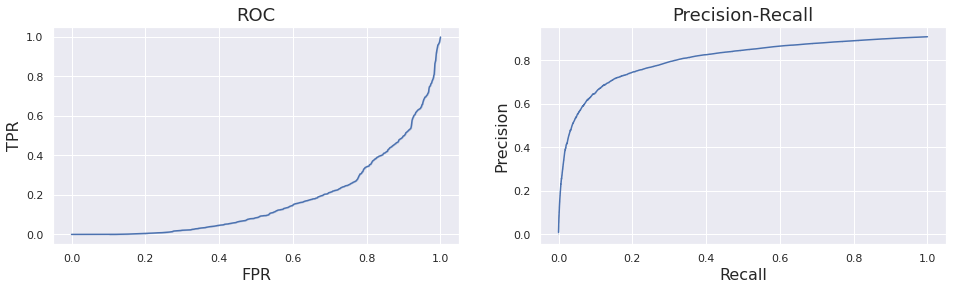

Inlier vs Outlier
----------------
ROC-AUC: 0.1765
PR-AUC: 0.8046
Avg Prec: 0.8046


In [55]:
metrics(test_score, outlier_score, plot=True, verbose=True)
plt.show()

**ABCD vs 2-year**

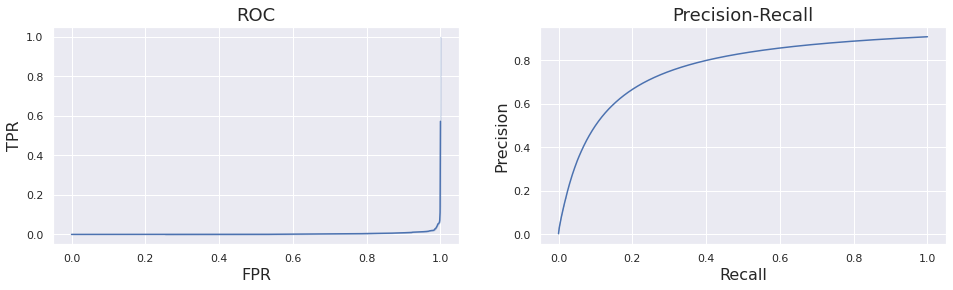

Inlier vs Outlier
----------------
ROC-AUC: 0.0032
PR-AUC: 0.7605
Avg Prec: 0.7605


In [56]:
metrics(test_score, outlier_score_2, plot=True, verbose=True)
plt.show()

## Train Data = L2-norm(Pixel Scores)

In [18]:
%%time
train_data, test_data = [], []
outlier_data_1, outlier_data_2 = [], [] 

for x, s in enumerate(SIGMAS):
    train_data.append(tf.norm(fashion_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    test_data.append(tf.norm(fashion_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    outlier_data_1.append(tf.norm(mnist_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    outlier_data_2.append(tf.norm(cifar_dist[x] * s, axis=[1,2], ord="euclidean").numpy())

train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)
outlier_data_1 = np.concatenate(outlier_data_1, axis=1)
outlier_data_2 = np.concatenate(outlier_data_2, axis=1)

CPU times: user 60.7 ms, sys: 40.4 ms, total: 101 ms
Wall time: 398 ms


In [19]:
train_data.shape, test_data.shape, outlier_data_1.shape

((5000, 10), (10000, 10), (10000, 10))

In [45]:
X_train, X_test =  test_data[:9000], test_data[9000:]

## UMAP

In [22]:
import umap
from sklearn.preprocessing import MinMaxScaler 

In [23]:
samples = np.concatenate((X_test, outlier_data_1, outlier_data_2))

labels = np.concatenate((np.zeros(X_test.shape[0]),
                         np.ones(outlier_data_1.shape[0]),
                         2*np.ones(outlier_data_2.shape[0])))

samples_mini = np.concatenate((X_test[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

captions_mini = np.concatenate(
    (["Fashion"]*1000,
     ["MNIST"]*1000,
     ["CIFAR"]* 1000))

captions = np.concatenate(
    (["Fashion"]*10000,
     ["MNIST"]*10000,
     ["CIFAR"]* 10000))

In [272]:
%%time
reducer = umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=100,
                    min_dist=0)
reducer.fit(samples)

CPU times: user 3min 9s, sys: 2min 45s, total: 5min 55s
Wall time: 2min 23s


UMAP(min_dist=0, n_neighbors=100, random_state=42)

In [316]:
%%time
embedding = reducer.transform(samples)

CPU times: user 1.09 ms, sys: 5.08 ms, total: 6.17 ms
Wall time: 5.05 ms


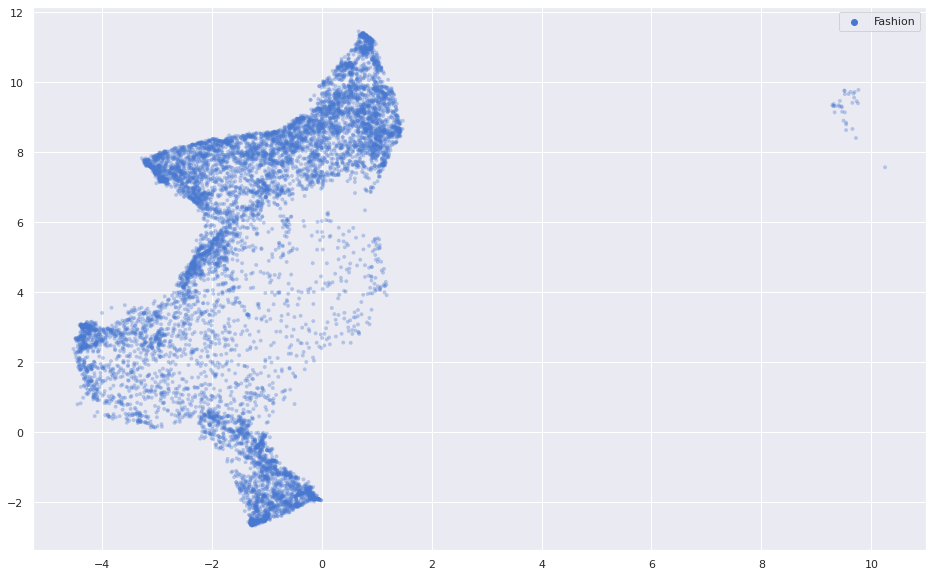

In [317]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=embedding[:10000, 0], y=embedding[:10000, 1], hue=captions[:10000], style=captions[:10000], s=15, alpha=0.35, palette="muted", edgecolor="none")

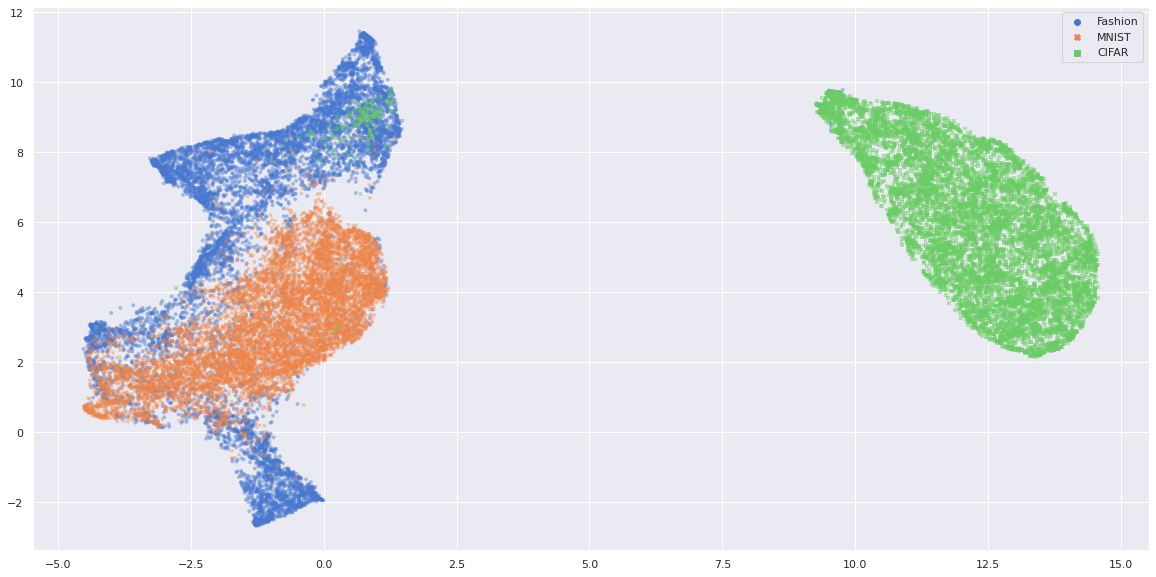

In [318]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=captions, style=captions, s=15, alpha=0.45, palette="muted", edgecolor="none")
plt.show()
# plt.close()

### Tighter Neighbourhood 

In [287]:
%%time
reducer_nn15 = umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=15,
                    min_dist=0.1)
reducer_nn15.fit(samples)

CPU times: user 1min 55s, sys: 2min 7s, total: 4min 2s
Wall time: 52.2 s


UMAP(random_state=42)

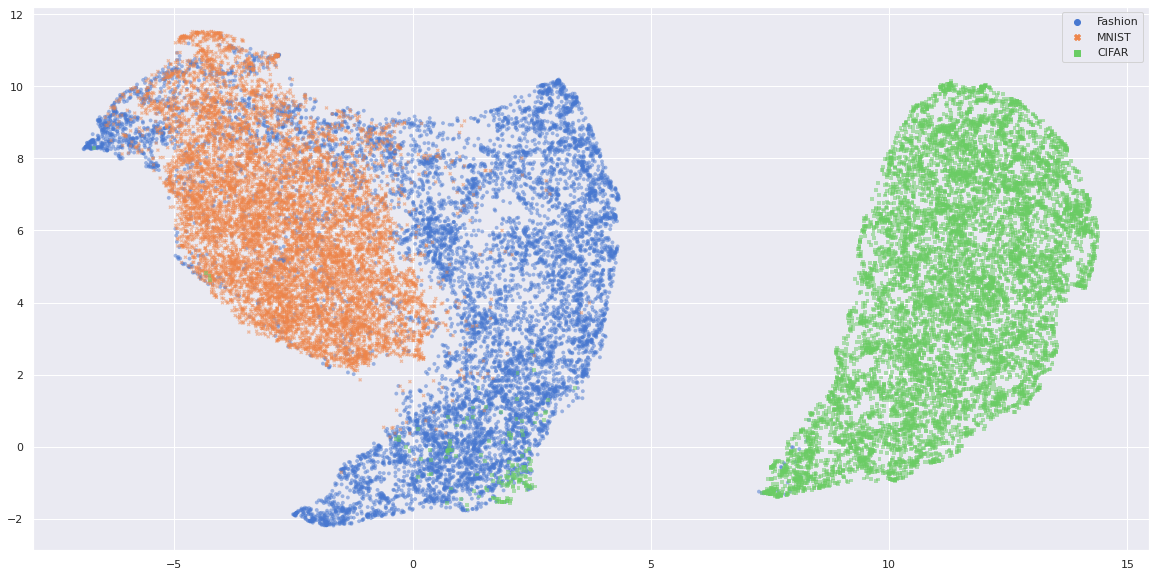

CPU times: user 940 ms, sys: 21.7 ms, total: 962 ms
Wall time: 960 ms


In [312]:
%%time
embedding = reducer_nn15.transform(samples)

plt.figure(figsize=(20,10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=captions, style=captions, s=15, alpha=0.5, palette="muted", edgecolor="none")
plt.show()
# plt.close()

In [24]:
%%time
reducer_3d = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=100,
                    min_dist=0)
reducer_3d.fit(samples)

CPU times: user 3min 49s, sys: 3min 13s, total: 7min 2s
Wall time: 2min 19s


UMAP(min_dist=0, n_components=3, n_neighbors=100, random_state=42)

In [25]:
%%time
embedding = reducer_3d.transform(samples)

CPU times: user 9.54 ms, sys: 2.37 ms, total: 11.9 ms
Wall time: 9 ms


In [43]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Score Norms",
    marker=dict(
        size=2,
        color=labels,
        colorscale="Blackbody",
        opacity=0.5,
        showscale=True
    ),
    text=captions
)

In [44]:
layout = go.Layout(
    title="3D UMAP",
    autosize=False,
    width=1000,
    height=800,
#     paper_bgcolor='#F5F5F5',
#     template="plotly"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
fig.show()

### Supervised UMAP

In [249]:
labels_train = np.concatenate((np.zeros(9000),
                         np.ones(9000),
                         2*np.ones(9000)))

samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

In [269]:
%%time

cheater = umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=100,
                    min_dist=0.1)
cheater.fit(samples_train, y=labels_train)

CPU times: user 3min 57s, sys: 3min 34s, total: 7min 31s
Wall time: 2min 30s


UMAP(n_neighbors=100, random_state=42)

In [278]:
%%time
embedding_mini = cheater.transform(samples_test)

CPU times: user 17.9 s, sys: 461 ms, total: 18.4 s
Wall time: 7.22 s


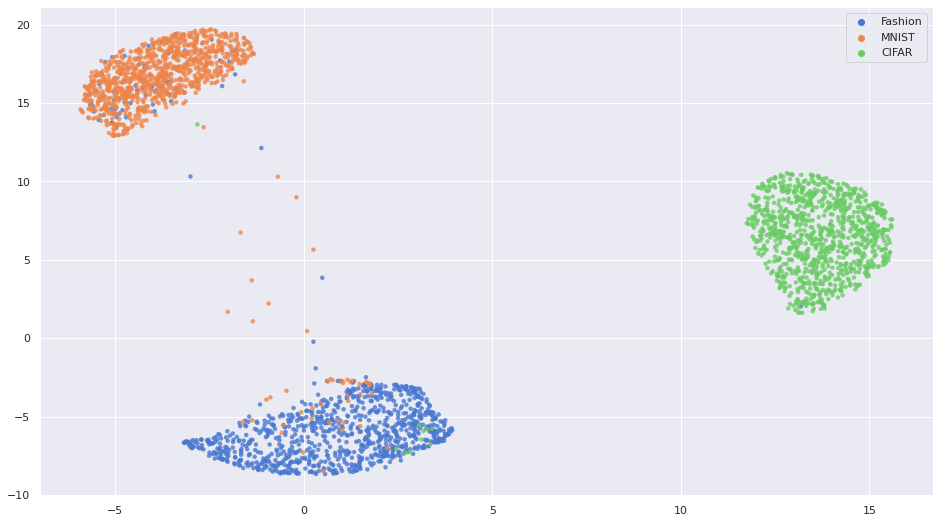

In [280]:
plt.figure(figsize=(16,9))
sns.scatterplot(x=embedding_mini[:, 0], y=embedding_mini[:, 1], hue=captions_mini, s=20, alpha=0.8, palette="muted", edgecolor="none")
plt.show()
# plt.close()

### OC-SVM

In [46]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from helper import plot_confusion_matrix

In [47]:
%%time
clf = svm.OneClassSVM(nu=0.01, kernel="rbf")
clf.fit(X_train)

CPU times: user 156 ms, sys: 7.21 ms, total: 163 ms
Wall time: 158 ms


OneClassSVM(nu=0.01)

In [51]:
y_true = np.concatenate((np.zeros(len(X_test)),
                         np.ones(len(outlier_data_1))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(X_test)) // (2)
outlier_pred = (1-clf.predict(outlier_data_1)) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=LABELS[1:3]))

              precision    recall  f1-score   support

     Fashion       0.09      0.99      0.17      1000
       MNIST       0.97      0.02      0.04     10000

    accuracy                           0.11     11000
   macro avg       0.53      0.51      0.10     11000
weighted avg       0.89      0.11      0.05     11000



> **Low precision => Low PPV => High False Positives**

In [53]:
y_true = np.concatenate((np.zeros(len(X_test)),
                         np.ones(1000)))

# Rescaling: 0 = inlier , 1 = outlier
outlier_pred = (1-clf.predict(outlier_data_2[:1000])) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=LABELS[[1,3]]))

              precision    recall  f1-score   support

     Fashion       0.96      0.99      0.98      1000
       CIFAR       0.99      0.96      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



### Grid Search
> **Defaults w/ rbf seem to work best**

In [54]:
y_train = np.ones(len(X_train))

ocsvm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("OCSVM", svm.OneClassSVM())
])


params = {"OCSVM__nu":[0.01, 0.02, 0.001],
          "OCSVM__gamma": ["scale", "auto"],
          "OCSVM__shrinking": [True, False],
          "OCSVM__kernel": ["rbf", "poly", "sigmoid"]
         }

grid = GridSearchCV(estimator=ocsvm_clf, param_grid=params, n_jobs=12,
                    cv=10, scoring="precision", verbose=1)
print(grid)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('OCSVM', OneClassSVM())]),
             n_jobs=12,
             param_grid={'OCSVM__gamma': ['scale', 'auto'],
                         'OCSVM__kernel': ['rbf', 'poly', 'sigmoid'],
                         'OCSVM__nu': [0.01, 0.02, 0.001],
                         'OCSVM__shrinking': [True, False]},
             scoring='precision', verbose=1)


In [55]:
%%time
grid.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 194 tasks      | elapsed:   14.0s


CPU times: user 1.67 s, sys: 1.79 s, total: 3.46 s
Wall time: 27.6 s


[Parallel(n_jobs=12)]: Done 360 out of 360 | elapsed:   27.3s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('OCSVM', OneClassSVM())]),
             n_jobs=12,
             param_grid={'OCSVM__gamma': ['scale', 'auto'],
                         'OCSVM__kernel': ['rbf', 'poly', 'sigmoid'],
                         'OCSVM__nu': [0.01, 0.02, 0.001],
                         'OCSVM__shrinking': [True, False]},
             scoring='precision', verbose=1)

In [91]:
grid.best_params_

{'OCSVM__gamma': 'scale',
 'OCSVM__kernel': 'rbf',
 'OCSVM__nu': 0.01,
 'OCSVM__shrinking': True}

In [59]:
%%time

clf = ocsvm_clf.set_params(**grid.best_params_)
clf.fit(train_data)

y_true = np.concatenate((np.zeros(len(X_test)),
                         np.ones(1000)))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(X_test)) // (2)
outlier_pred = (1-clf.predict(outlier_data_1[:1000])) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=LABELS[[1,2]]))

              precision    recall  f1-score   support

     Fashion       0.50      0.99      0.67      1000
       MNIST       0.70      0.03      0.05      1000

    accuracy                           0.51      2000
   macro avg       0.60      0.51      0.36      2000
weighted avg       0.60      0.51      0.36      2000

CPU times: user 66.1 ms, sys: 3.63 ms, total: 69.7 ms
Wall time: 66.8 ms


Confusion matrix, without normalization
[[0.989 0.011]
 [0.974 0.026]]
Overall Accuracy: 0.5075


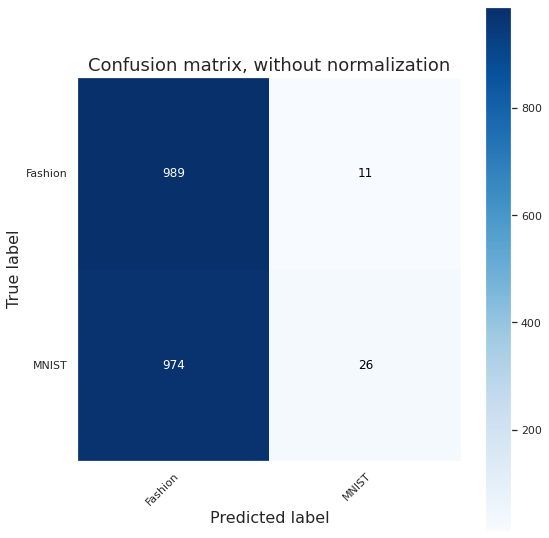

In [58]:
plot_confusion_matrix(y_true, y_pred, classes=LABELS[[1,2]])
plt.grid(False)

## GMM

In [62]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(10,21,2),
                  GMM__covariance_type = ['spherical', 'diag', "full", "tied"])

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   47.0s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:  1.1min finished


CPU times: user 2min 49s, sys: 2min 25s, total: 5min 15s
Wall time: 1min 15s


In [64]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.256545 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
-8.686791 (0.116422) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 10}
-8.331449 (0.140918) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 12}
-8.061780 (0.109211) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 14}
-7.838670 (0.114396) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 16}
-7.684938 (0.146601) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 18}
-7.547368 (0.172929) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 20}
-8.165425 (0.102477) with: {'GMM__covariance_type': 'diag', 'GMM__n_components': 10}
-7.848522 (0.104151) with: {'GMM__covariance_type': 'diag', 'GMM__n_components': 12}
-7.522341 (0.093991) with: {'GMM__covariance_type': 'diag', 'GMM__n_components': 14}
-7.353060 (0.101590) with: {'GMM__covariance_type'

In [61]:
Best: 0.071903 using {'GMM__covariance_type': 'full', 'GMM__n_components': 10}

Best: 0.071903 using {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
---------------------------------------------------------------------------


In [96]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: -13.784854 using {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
---------------------------------------------------------------------------


In [137]:
### Using BIC - Likelihoods NOT as good as CV

# bic_gmm = None
# lowest_bic = np.infty
# bics = {}
# n_components_range = range(1, 11)
# cv_types = ['spherical', 'tied', 'diag', 'full']
# scaler = StandardScaler()
# _x_train = scaler.fit_transform(X_train)

# for cv_type in cv_types:
#     for n_components in n_components_range:
#         # Fit a Gaussian mixture with EM
#         gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
#         gmm.fit(_x_train)
#         bic = gmm.bic(_x_train)
        
#         if n_components in bics:
#             bics[n_components].append(bic)
#         else:
#             bics[n_components] = [bic]
        
#         if bic < lowest_bic:
#             lowest_bic = bic
#             bic_gmm = gmm
# bic_gmm

# bics = pd.DataFrame(bics, index=['spherical', 'tied', 'diag', 'full']).T
# bics.plot(kind="bar", figsize=(20,4))

# print("Training Likelihood: {:.3f}".format(bic_gmm.score(X_train)))
# print("Testing Likelihood: {:.3f}".format(bic_gmm.score(X_test)))
# print("1-year Likelihood: {:.3f}".format(bic_gmm.score(outlier_data_1)))
# print("2-year Likelihood: {:.3f}".format(bic_gmm.score(outlier_data_2)))

In [65]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: 0.499
Fashion Likelihood: 0.451
MNIST Likelihood: -4.539
CIFAR Likelihood: -31.984


In [66]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

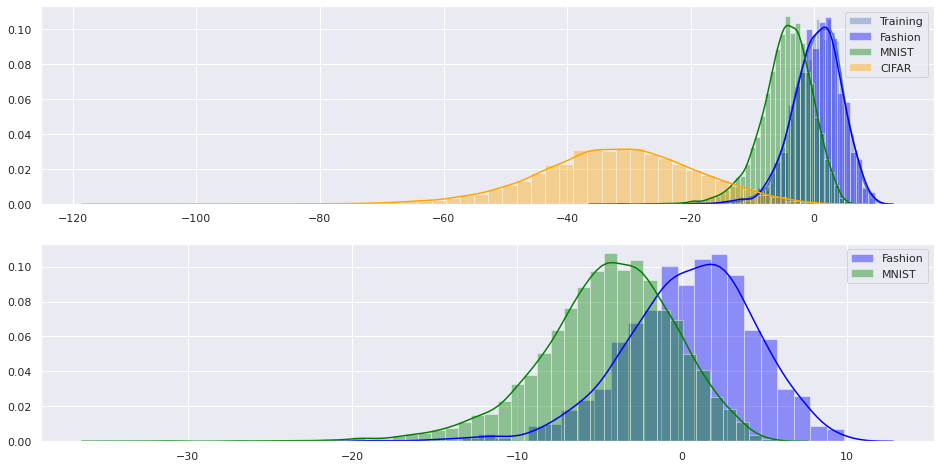

In [71]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score, label="Training", ax=axs[0])
# sns.distplot(train_score, label="Training", ax=axs[1])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])


# sns.distplot(outlier_score, label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])

# sns.distplot(outlier_score_2, label=LABELS[3], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])


sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

# sns.distplot(inlier_score, color="red", label=labels[0])

In [130]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(20,31),
                  GMM__covariance_type = ["full"])

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

CPU times: user 585 µs, sys: 0 ns, total: 585 µs
Wall time: 629 µs


In [131]:
grid_result_test = grid.fit(test_data[:9000])
print("Best: %f using %s" % (grid_result_test.best_score_, grid_result_test.best_params_))
print("-----"*15)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   17.3s
[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:  1.0min finished


Best: 0.280312 using {'GMM__covariance_type': 'full', 'GMM__n_components': 27}
---------------------------------------------------------------------------


In [132]:
means = grid_result_test.cv_results_['mean_test_score']
stds = grid_result_test.cv_results_['std_test_score']
params = grid_result_test.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.255780 (0.109870) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
0.254680 (0.096781) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 21}
0.270664 (0.104199) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 22}
0.260469 (0.104789) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 23}
0.276521 (0.103427) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 24}
0.271285 (0.087168) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 25}
0.266730 (0.105528) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 26}
0.280312 (0.100501) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 27}
0.276231 (0.110272) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 28}
0.260655 (0.113329) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 29}
0.263830 (0.087536) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 30}


In [129]:
means = grid_result_test.cv_results_['mean_test_score']
stds = grid_result_test.cv_results_['std_test_score']
params = grid_result_test.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-14.192043 (0.154951) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 1}
-12.486674 (0.144892) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 2}
-11.456636 (0.113930) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 3}
-10.599940 (0.104249) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 4}
-10.064626 (0.109483) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 5}
-9.659627 (0.069098) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 6}
-9.323429 (0.076317) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 7}
-9.054515 (0.099172) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 8}
-8.807007 (0.104515) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 9}
-8.654501 (0.088319) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 10}
-8.507306 (0.075575) with: {'GMM__covariance_type': 'spherical', 'GMM__n_components': 11}
-8.333253 (0.0

In [123]:
Best: 0.262263 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}

Pipeline(steps=[('scaler', StandardScaler()),
                ('GMM', GaussianMixture(n_components=20))])

In [133]:

best_gmm = grid_result_test.best_estimator_
# 
print("Training Likelihood: {:.3f}".format(best_gmm.score(test_data[:9000])))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm.score(test_data[9000:])))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm.score(outlier_data_2)))

Training Likelihood: 0.603
Fashion Likelihood: 0.128
MNIST Likelihood: -4.708
CIFAR Likelihood: -46.260


In [134]:
train_score = best_gmm.score_samples(X_test[:9000])
test_score = best_gmm.score_samples(X_test[9000:])
outlier_score = best_gmm.score_samples(outlier_data_1)
outlier_score_2 = best_gmm.score_samples(outlier_data_2)

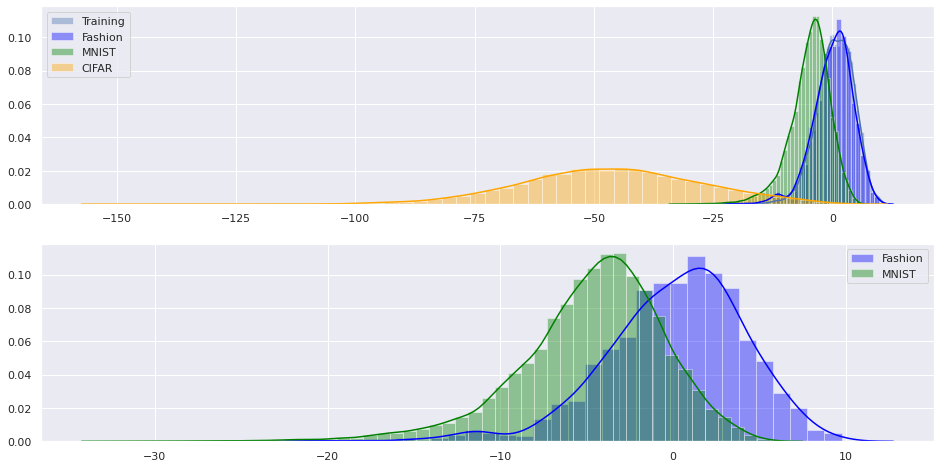

In [135]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score, label="Training", ax=axs[0])
# sns.distplot(train_score, label="Training", ax=axs[1])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])


# sns.distplot(outlier_score, label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])

# sns.distplot(outlier_score_2, label=LABELS[3], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])


sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

# sns.distplot(inlier_score, color="red", label=labels[0])

**Fashion vs MNIST**

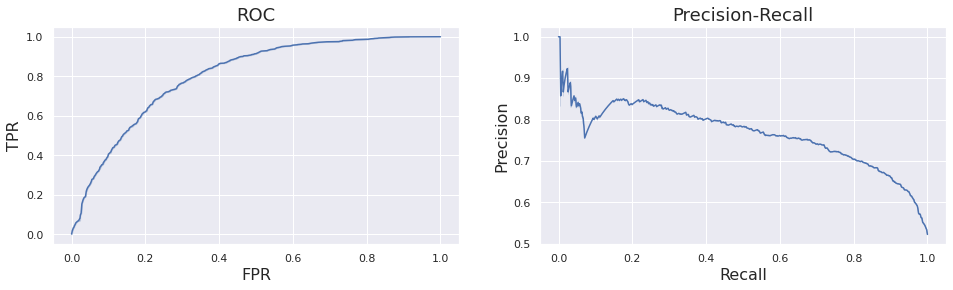

Inlier vs Outlier
----------------
ROC-AUC: 0.8036
PR-AUC: 0.7657
Avg Prec: 0.7661


In [137]:
metrics(-test_score, -outlier_score[:1000], plot=True, verbose=True)
plt.show()

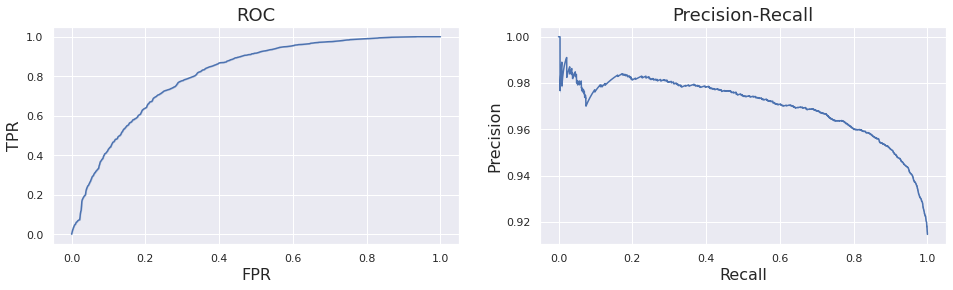

Inlier vs Outlier
----------------
ROC-AUC: 0.8099
PR-AUC: 0.9703
Avg Prec: 0.9703


In [136]:
metrics(-test_score, -outlier_score, plot=True, verbose=True)
plt.show()

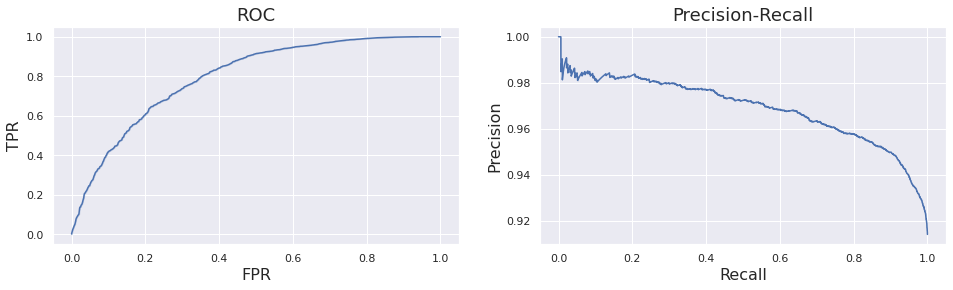

Inlier vs Outlier
----------------
ROC-AUC: 0.7969
PR-AUC: 0.9690
Avg Prec: 0.9690


In [110]:
metrics(-test_score, -outlier_score, plot=True, verbose=True)
plt.show()

**Fashion vs CIFAR**

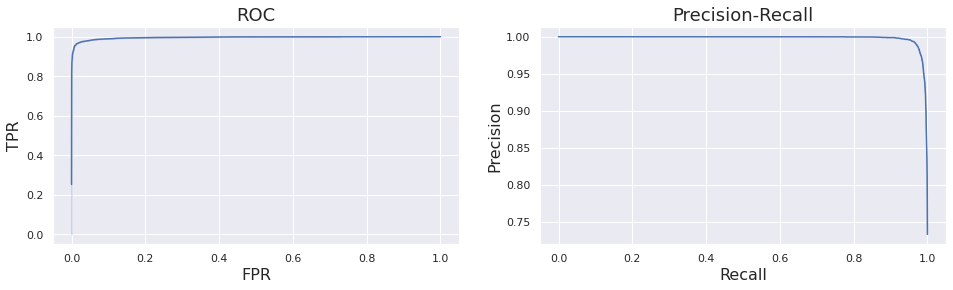

Inlier vs Outlier
----------------
ROC-AUC: 0.9961
PR-AUC: 0.9982
Avg Prec: 0.9982


In [66]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()

# Try a classifier ...?

In [75]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm_clf =  make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [78]:
labels_train = np.concatenate((np.zeros(9000),
                         np.ones(9000),
                         2*np.ones(9000)))

labels_test = np.concatenate((np.zeros(1000),
                         np.ones(1000),
                         2*np.ones(1000)))

samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

In [79]:
svm_clf.fit(samples_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [84]:
test_pred = svm_clf.predict(samples_test)
test_pred[:]

array([0., 0., 0., ..., 2., 2., 2.])

In [85]:
np.unique(test_pred)

array([0., 1., 2.])

In [87]:
print(classification_report(labels_test, test_pred, target_names=LABELS[1:4]))

              precision    recall  f1-score   support

     Fashion       0.97      0.92      0.94      1000
       MNIST       0.93      0.98      0.95      1000
       CIFAR       1.00      0.99      0.99      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [92]:
%%time
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC())
])

params = {"SVM__C": [0.1, 1, 3, 10],
          "SVM__gamma": ["scale", "auto"],
          "SVM__shrinking": [True, False]
         }

grid = GridSearchCV(estimator=svm_clf, param_grid=params, n_jobs=10,
                    cv=10, scoring="accuracy", verbose=1)
print(grid)
grid_results = grid.fit(samples_train, labels_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             n_jobs=10,
             param_grid={'SVM__C': [0.1, 1, 3, 10],
                         'SVM__gamma': ['scale', 'auto'],
                         'SVM__shrinking': [True, False]},
             scoring='accuracy', verbose=1)
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   19.2s
[Parallel(n_jobs=10)]: Done 160 out of 160 | elapsed:  1.1min finished


CPU times: user 4.47 s, sys: 1.52 s, total: 6 s
Wall time: 1min 11s


In [95]:
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
print("-----"*15)
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.964556 using {'SVM__C': 10, 'SVM__gamma': 'auto', 'SVM__shrinking': True}
---------------------------------------------------------------------------
0.956556 (0.004203) with: {'SVM__C': 0.1, 'SVM__gamma': 'scale', 'SVM__shrinking': True}
0.956519 (0.004224) with: {'SVM__C': 0.1, 'SVM__gamma': 'scale', 'SVM__shrinking': False}
0.956556 (0.004203) with: {'SVM__C': 0.1, 'SVM__gamma': 'auto', 'SVM__shrinking': True}
0.956519 (0.004224) with: {'SVM__C': 0.1, 'SVM__gamma': 'auto', 'SVM__shrinking': False}
0.961111 (0.002949) with: {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__shrinking': True}
0.961111 (0.002949) with: {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__shrinking': False}
0.961111 (0.002949) with: {'SVM__C': 1, 'SVM__gamma': 'auto', 'SVM__shrinking': True}
0.961111 (0.002949) with: {'SVM__C': 1, 'SVM__gamma': 'auto', 'SVM__shrinking': False}
0.962741 (0.002687) with: {'SVM__C': 3, 'SVM__gamma': 'scale', 'SVM__shrinking': True}
0.962741 (0.002687) with: {'SVM__C': 3, 'SVM__gamma

In [96]:
svm_clf.set_params(**grid_results.best_params_)
svm_clf.fit(samples_train, labels_train)

test_pred = svm_clf.predict(samples_test)
print(classification_report(labels_test, test_pred, target_names=LABELS[1:4]))

              precision    recall  f1-score   support

     Fashion       0.97      0.93      0.95      1000
       MNIST       0.93      0.98      0.95      1000
       CIFAR       1.00      0.99      0.99      1000

    accuracy                           0.96      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.97      0.96      0.97      3000



## Bayesian GMM

In [139]:
from sklearn.mixture import BayesianGaussianMixture

In [140]:
%%time
bgmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("BGMM", BayesianGaussianMixture())
])

param_grid = dict(BGMM__n_components = range(2, 21, 2),
                  BGMM__covariance_type = ["full"],
                  BGMM__max_iter=[200],
                  BGMM__init_params= ["kmeans", "random"],
                  BGMM__n_init=[3],
                  BGMM__weight_concentration_prior_type=["dirichlet_process", "dirichlet_distribution"]
                 )

grid = GridSearchCV(estimator=bgmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=12, verbose=1)

grid_result_bgmm = grid.fit(X_test[:9000])

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   16.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed: 19.4min finished


CPU times: user 25min 24s, sys: 44min 30s, total: 1h 9min 55s
Wall time: 21min 12s


/usr/local/lib/python3.6/dist-packages/scikit_learn-0.23.1-py3.6-linux-x86_64.egg/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [141]:
print("Best: %f using %s" % (grid_result_bgmm.best_score_, grid_result_bgmm.best_params_))

Best: 0.192407 using {'BGMM__covariance_type': 'full', 'BGMM__init_params': 'kmeans', 'BGMM__max_iter': 200, 'BGMM__n_components': 20, 'BGMM__n_init': 3, 'BGMM__weight_concentration_prior_type': 'dirichlet_process'}


In [74]:
# means = grid_result_bgmm.cv_results_['mean_test_score']
# stds = grid_result_bgmm.cv_results_['std_test_score']
# params = grid_result_bgmm.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [162]:
best_bgmm_clf = grid_result_bgmm.best_estimator_

In [163]:
print("Training Likelihood: {:.3f}".format(best_bgmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(labels[1], best_bgmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(labels[2], best_bgmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(labels[3], best_bgmm_clf.score(outlier_data_2)))

Training Likelihood: 0.189
Fashion Likelihood: -0.030
MNIST Likelihood: -75.292
Cifar Likelihood: -401.103


In [169]:
train_score = best_bgmm_clf.score_samples(X_train)
test_score = best_bgmm_clf.score_samples(X_test)
outlier_score = best_bgmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_bgmm_clf.score_samples(outlier_data_2)

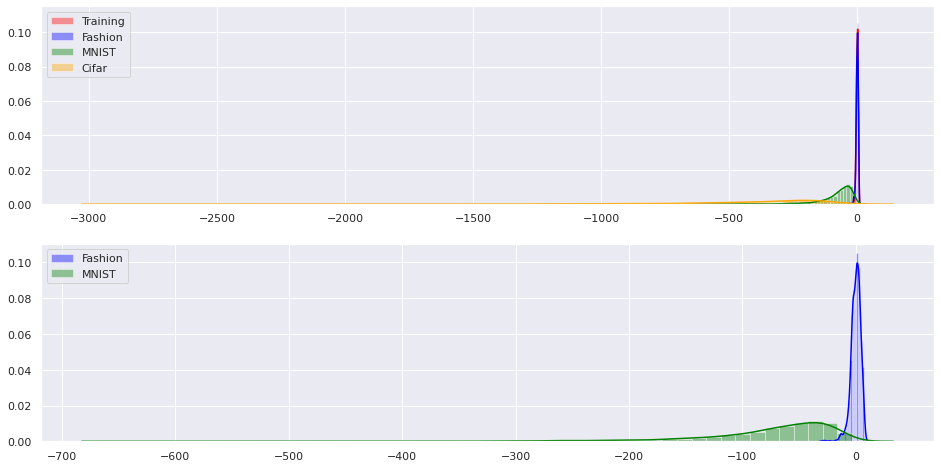

In [170]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
# sns.distplot(train_score, label="Training", ax=axs[1])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])


# sns.distplot(outlier_score, label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])

# sns.distplot(outlier_score_2, label=LABELS[3], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])


sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

# sns.distplot(inlier_score, color="red", label=labels[0])

**Fashion vs MNIST**

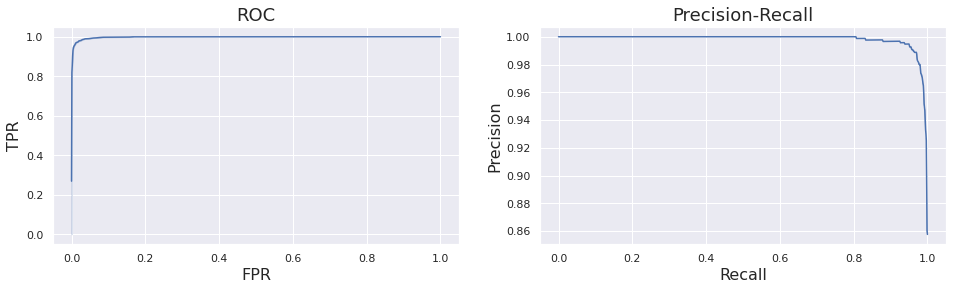

Inlier vs Outlier
----------------
ROC-AUC: 0.9981
PR-AUC: 0.9982
Avg Prec: 0.9982


In [171]:
metrics(-test_score, -outlier_score, plot=True, verbose=True)
plt.show()

**Fashion vs CIFAR**

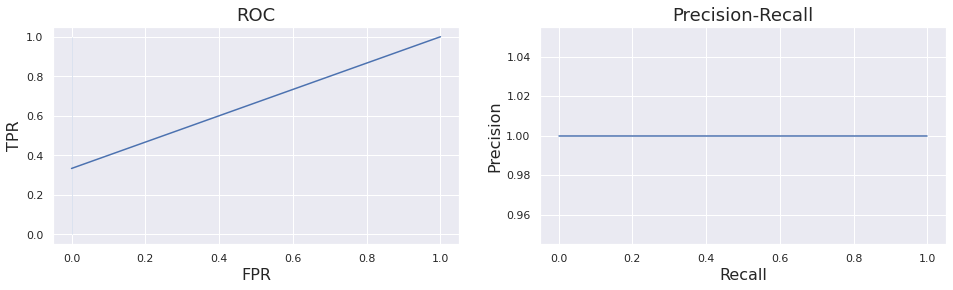

Inlier vs Outlier
----------------
ROC-AUC: 1.0000
PR-AUC: 1.0000
Avg Prec: 1.0000


In [172]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()